# Utqiagvik **Fall** Analysis - Wind Speed and Direction
- Bowhead whale hunting happens in fall (September/October/November) and is dependent on wind conditions, which drive waves.
- Notebook by Alice DuVivier (NCAR)
- Used to work with NPL 2025a, but it didn't have "windrose", so created new environment - analysis_windrose. Followed this guidance for modifying windrose to be prettier. https://medium.com/@benjamin.ganko/wind-roses-in-python-pretty-straight-forward-sort-of-d859e64c5fba
- January 2026

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mtick
from metpy.calc import wind_speed
from metpy.calc import wind_direction
from windrose import WindroseAxes
import math

## Load Data

In [2]:
# set model to load
# options: 'cesm1le', 'cesm2le', 'cesm2cmip5'
model = 'cesm2le'

In [3]:
# set base directory
dir_base = '/glade/campaign/cgd/ppc/duvivier/arctic_actionable/DATA/'

In [4]:
# set path for files

if model == 'cesm2le':
    dir_in = dir_base+'cesm2-le_utqiagvik/'
elif model == 'cesm1le':
    dir_in = dir_base+'cesm1-le_utqiagvik/'
elif model == 'cesm2cmip5':
    dir_in = dir_base+'cesm2-cmip5_utqiagvik/'

### Load model Wind Vector data
- Lowest Level (~60m) U and V
- Calculate daily wind speed and direction from this

In [5]:
# set file and then load data
if model == 'cesm2le':
    file_in_1 = 'Utqiagvik_CESM2-LE_1920-2100_daily-UBOT.nc'
    file_in_2 = 'Utqiagvik_CESM2-LE_1920-2100_daily-VBOT.nc'
elif model == 'cesm2cmip5':
    file_in_1 = 'Utqiagvik_CESM2-CMIP5_1920-2100_daily-UBOT.nc'
    file_in_2 = 'Utqiagvik_CESM2-CMIP5_1920-2100_daily-VBOT.nc'
elif model == 'cesm1le':
    file_in_1 = 'Utqiagvik_CESM1-LE_1920-2100_daily-UBOT.nc'
    file_in_2 = 'Utqiagvik_CESM1-LE_1920-2100_daily-VBOT.nc'

# load data
ds1 = xr.open_dataset(dir_in+file_in_1, decode_times=False)
ds2 = xr.open_dataset(dir_in+file_in_2, decode_times=False)

In [6]:
# look at dataset
ds1

# check out the time info - find that it's not intuitive
ds1.time

# to make useable time coordinate, create arrays for yyyy-mm-dd (NO LEAP!)
# We know it's daily data for 19790101-20211231, not including leap days.

# create full range of dates at daily frequency
dr = pd.date_range(start='1/1/1920', end='12/31/2100', freq='D')
# remove leap days
dates = dr[(dr.day != 29) | (dr.month != 2)]
# check that the # times matches above
print(dates.shape)

# assign the time coordinate
ds1['time'] = dates
ds2['time'] = dates

(66065,)


In [7]:
# get the two vector datasets
uwnd = ds1.UBOT
vwnd = ds2.VBOT

In [8]:
# get some information about dimensions
ntime = len(ds1.time)
nens = len(ds1.member_id)
print(ntime,nens)

# write a new array
members = np.arange(0,nens,1)

66065 50


In [9]:
# use metpy to calculate wind speed and direction
# need to loop through each ensemble member because the function doesn't work with 2D

ws_array = np.zeros([nens,ntime])
wd_array = np.zeros([nens,ntime])

# loop through each year to get the data
for index, mm in enumerate(members):
    #print(mm)
    # get this ensemble member's u and v vectors
    utmp = uwnd.isel(member_id=mm)
    vtmp = vwnd.isel(member_id=mm)
    # calculate ws and wd
    ws_array[index,:] = wind_speed(utmp,vtmp)
    wd_array[index,:] = wind_direction(utmp,vtmp)

# convert the numpy arrays to xarrays for easier plotting
ws_all = xr.DataArray(ws_array,dims=('member_id','time'))
ws_all['member_id'] = uwnd.member_id
ws_all['time'] = uwnd.time

wd_all = xr.DataArray(wd_array,dims=('member_id','time'))
wd_all['member_id'] = uwnd.member_id
wd_all['time'] = uwnd.time

In [10]:
ws_all

<xarray.DataArray (member_id: 50, time: 66065)> Size: 26MB
array([[ 5.3258996 ,  2.57172608, 10.34662533, ..., 13.9810791 ,
        16.63698196,  7.25092793],
       [ 7.86306763,  1.8271687 ,  2.57134271, ..., 12.49061871,
        11.5948    , 10.05683994],
       [ 5.64318085,  5.55779696, 13.79405594, ...,  8.71007061,
        11.34421253, 14.31566238],
       ...,
       [ 6.96929598,  9.7349987 , 10.76040459, ...,  5.46587944,
         6.76105309,  5.79737997],
       [ 6.98594761,  5.88007975,  2.7503221 , ..., 15.52086735,
        18.77915001, 22.5077095 ],
       [ 9.96329403,  3.9251399 ,  7.28387499, ...,  7.47107744,
         4.64160776,  6.12194204]], shape=(50, 66065))
Coordinates:
  * member_id  (member_id) int64 400B 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * time       (time) datetime64[ns] 529kB 1920-01-01 1920-01-02 ... 2100-12-31
    lat        float64 8B ...
    lon        float64 8B ...

## Process Fall Wind data - Model
- September, October, November only
- Timeseries: calculate means and standard deviations over spring months
- Time of Emergence: Use baseline 51 years (1925-1975). ToE happens when ensemble mean drops below the +/-2 STD from baseline period
- Fractions below some thresholds

In [11]:
# get some dimensions

# total ensemble members - got this earlier
print(nens)

# years from 1920-2100
years_model = np.arange(1920,2101,1)
nyrs = len(years_model)
print(nyrs)

# days are all days in SON
ndays = 30 + 31 + 30

# get total number of data points per year for all ensembles and all months
times_tot = ndays*nens

50
181


In [12]:
# subset to just this season
data_model_ws_seas = ws_all.isel(time=ws_all.time.dt.month.isin([9,10,11]))
data_model_wd_seas = wd_all.isel(time=wd_all.time.dt.month.isin([9,10,11]))

### Daily Data Means

In [13]:
# WS
data_model = data_model_ws_seas

# preallocate some arrays
avg_array = np.zeros([nyrs])
std_array = np.zeros([nyrs])

# loop through each year to get the data
for index, yy in enumerate(years_model):
    #print(f"Index {index}: {yy}")
    # get the data for this year
    temp1 = data_model.isel(time=data_model.time.dt.year.isin([yy]))
    # make 1d
    temp2 = temp1.stack(all=("member_id","time"))
    # calculate mean
    avg_array[index] = temp2.mean(dim='all')
    # calculate standard deviation
    std_array[index] = temp2.std(dim='all')

# convert the numpy arrays to xarrays for easier plotting
data_model_ws_avg = xr.DataArray(avg_array,dims=('years'))
data_model_ws_avg['years'] = years_model
data_model_ws_std = xr.DataArray(std_array,dims=('years'))
data_model_ws_std['years'] = years_model

### Time of Emergence
- For baseline, use 50 years: 1925-1975
- ToE happens when ensemble mean drops below the +/-2 STD from baseline period

In [14]:
# subset data to just 1925-1975
yy_sub = np.arange(1925,1976,1)

In [15]:
# WS
data_model = data_model_ws_seas
model_avg = data_model_ws_avg

### Get baseline means and standard deviation
# subset years
data_model_sub = data_model.isel(time=data_model.time.dt.year.isin([yy_sub]))
# stack into one dimension
data_model_sub_1d = data_model_sub.stack(all=("member_id","time"))
# calculate mean and standard deviation over all these points
avg_baseline = data_model_sub_1d.mean(dim='all')
print(avg_baseline.values)
std_baseline = data_model_sub_1d.std(dim='all')
print(std_baseline.values)

### Find TOE
# When ensemble mean falls **below** baseline mean **minus** 2STD
toe_thresh_hi = avg_baseline + 2*std_baseline
toe_thresh_low = avg_baseline - 2*std_baseline
# make xarray of where the output has emerged
emerged = model_avg < toe_thresh_low.values
# Check if there is a ToE
is_all_false = (emerged == False).all()
# If there is a ToE, calculate the index where it happens
if is_all_false == False:
    print('ToE exists, calculating index')
    ToE_flag = True
    first_index = emerged.argmax(dim='years')
    # calculate x and y for plot
    x_toe = emerged[first_index].years.values
    y_toe = model_avg[first_index].values
    # print the year of ToE
    print(x_toe)
else:
    print('No ToE exists')
    ToE_flag = False
    x_toe = np.full((1, 1), np.nan)
    y_toe = np.full((1, 1), np.nan)

### Write variables
data_model_ws_x_toe = x_toe
data_model_ws_y_toe = y_toe
data_model_ws_toe_thresh_hi = toe_thresh_hi.values
data_model_ws_toe_thresh_low = toe_thresh_low.values

8.124547914874977
4.047665997961645
No ToE exists


### Model: Fraction of days above thresholds

Calculate fraction of days with Wind Speed above some thresholds
- Small boat: WS>=6m/s
- Big boat:   WS>=11m/s

Beaufort Scale (https://windy.app/blog/wind-speed-beaufort-scale.html)
- Strong Breeze: WS>=11m/s
- Gale: WS>=17m/s

In [16]:
# WS
data_model = data_model_ws_seas

# set thresholds
thresh1 = 11.0
thresh2 = 17.0

# preallocate arrays
array_1 = np.zeros([nyrs])
array_2 = np.zeros([nyrs])

# loop through each year to calculate fractions
for index, yy in enumerate(years_model):
    #print(f"Index {index}: {yy}")
    # get data for this year
    temp1 = data_model.isel(time=data_model.time.dt.year.isin([yy]))
    # make 1d and put into the new array
    temp2 = temp1.stack(all=("member_id","time"))
    temp2 = temp2.compute()
    # count days with WS>11m/s conditions
    count = len(temp2.where((temp2 > thresh1),drop=True))
    array_1[index] = 100.0*(count/times_tot)    
    # count days with WS>17m/s conditions
    count = len(temp2.where((temp2 > thresh2),drop=True))
    array_2[index] = 100.0*(count/times_tot)

# convert the numpy arrays to xarrays for easier plotting
data_model_ws_thresh1 = xr.DataArray(array_1,dims=('years'))
data_model_ws_thresh1['years'] = years_model
data_model_ws_thresh2 = xr.DataArray(array_2,dims=('years'))
data_model_ws_thresh2['years'] = years_model

### Get Data for decadal histograms and wind roses

In [17]:
# set year ranges for each decade

# 1995: 1993-1997
yy1_1 = 1993
yy1_2 = 1997
# 2045: 2043-2047
yy2_1 = 2043
yy2_2 = 2047
# 2095: 2093-2097
yy3_1 = 2093
yy3_2 = 2097

In [18]:
# WS
data_model = ws_all

# preallocate arrays
data_array = np.zeros([nyrs,times_tot])

# loop through each year to get the data
for index, yy in enumerate(years_model):
    #print(f"Index {index}: {yy}")
    # get the data for this year
    temp1 = data_model.isel(time=data_model.time.dt.year.isin([yy]))
    # get fall months only
    temp2 = temp1.isel(time=temp1.time.dt.month.isin([9,10,11]))
    # make 1d and put into the new array
    temp3 = temp2.stack(all=("member_id","time"))
    # put into new array
    data_array[index,:] = temp3

# convert the numpy arrays to xarrays for easier plotting
ws_fall = xr.DataArray(data_array,dims=('years','N'))
ws_fall['years'] = years_model

In [19]:
# subset data by the three decades and stack so that all data is in one dimension
data_sub = ws_fall

# decade 1
ws_dec1 = data_sub.where((data_sub.years >= yy1_1)&(data_sub.years <= yy1_2),drop=True).stack(npts=("years","N"))
# decade 2
ws_dec2 = data_sub.where((data_sub.years >= yy2_1)&(data_sub.years <= yy2_2),drop=True).stack(npts=("years","N"))
# decade 3
ws_dec3 = data_sub.where((data_sub.years >= yy3_1)&(data_sub.years <= yy3_2),drop=True).stack(npts=("years","N"))

In [20]:
# WD
data_model = wd_all

# preallocate arrays
data_array = np.zeros([nyrs,times_tot])

# loop through each year to get the data
for index, yy in enumerate(years_model):
    #print(f"Index {index}: {yy}")
    # get the data for this year
    temp1 = data_model.isel(time=data_model.time.dt.year.isin([yy]))
    # get fall months only
    temp2 = temp1.isel(time=temp1.time.dt.month.isin([9,10,11]))
    # make 1d and put into the new array
    temp3 = temp2.stack(all=("member_id","time"))
    # put into new array
    data_array[index,:] = temp3

# convert the numpy arrays to xarrays for easier plotting
wd_fall = xr.DataArray(data_array,dims=('years','N'))
wd_fall['years'] = years_model

In [21]:
# subset data by the three decades and stack so that all data is in one dimension
data_sub = wd_fall

# decade 1
wd_dec1 = data_sub.where((data_sub.years >= yy1_1)&(data_sub.years <= yy1_2),drop=True).stack(npts=("years","N"))
# decade 2
wd_dec2 = data_sub.where((data_sub.years >= yy2_1)&(data_sub.years <= yy2_2),drop=True).stack(npts=("years","N"))
# decade 3
wd_dec3 = data_sub.where((data_sub.years >= yy3_1)&(data_sub.years <= yy3_2),drop=True).stack(npts=("years","N"))

## Plots

In [22]:
# set an output directory for figures
dir_out = '/glade/campaign/cgd/ppc/duvivier/arctic_actionable/utqiagvik_analysis/version_5/'

In [23]:
# set colors 
if model == 'cesm2le':
    c1 = 'royalblue'
    c2 = 'lightskyblue'
    lab = 'CESM2-LE'
elif model == 'cesm1le':
    c1 = 'firebrick'
    c2 = 'pink'
    lab = 'CESM1-LE'
elif model == 'cesm2cmip5':
    c1 = 'gold'
    c2 = 'khaki'
    lab = 'CESM2-CMIP5'

In [24]:
# set number of bins 
n_bins = 50  # roughly 0.5m/s bins
#n_bins = 25  # roughly 1m/s bins

### Timeseries and Histogram

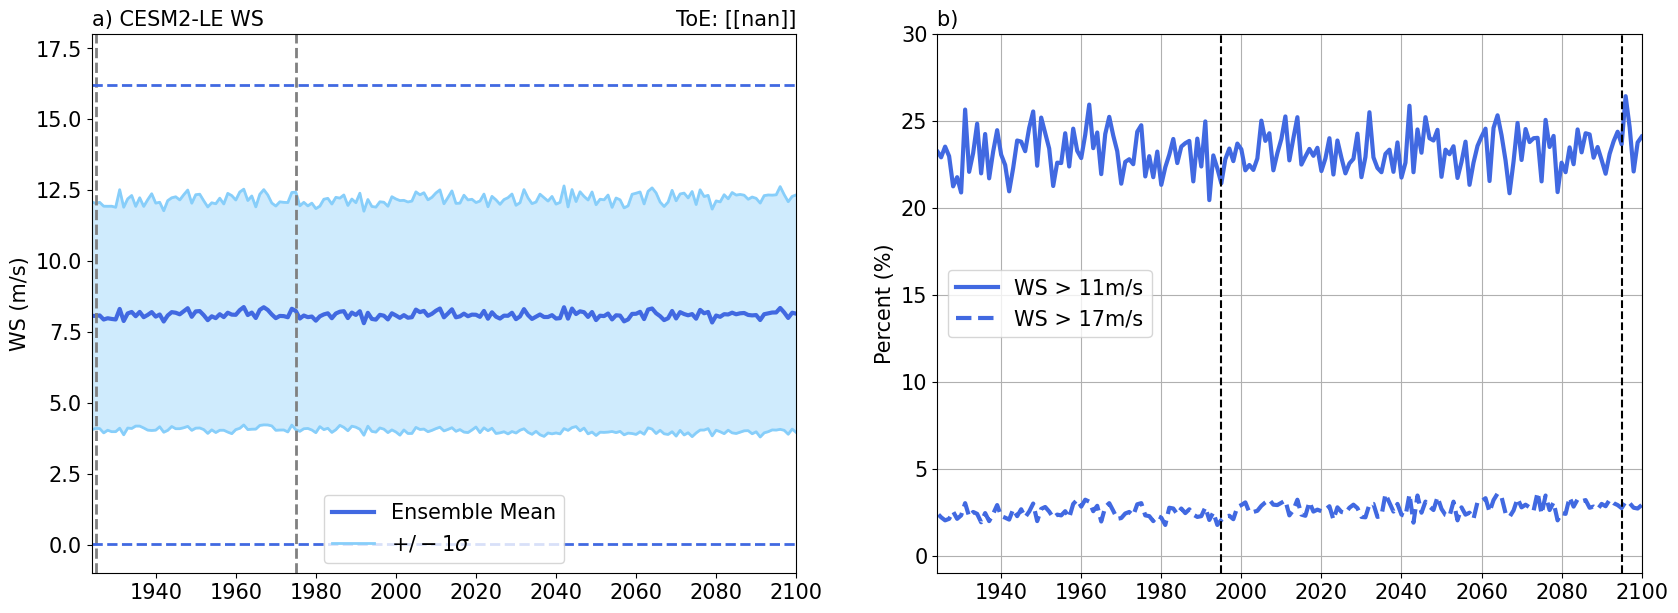

In [31]:
# create figure
fout = 'fig_5_utq_fall_wind_timeseries_'+model

fig = plt.figure(figsize=(20,7))

# Make subplot - note it's nrow x ncol x index (starting upper left) - 3 rows x 2 columns
### Plot 1 - SIC timeseries ###
ax = fig.add_subplot(1,2,1)
# data to plot
model_avg = data_model_ws_avg
model_std = data_model_ws_std
toe_x = data_model_ws_x_toe
toe_y = data_model_ws_y_toe
toe_hi = data_model_ws_toe_thresh_hi
toe_lo = data_model_ws_toe_thresh_low
toe = str(toe_x)
## Model Data
ax.plot(years_model,model_avg,color=c1,label='Ensemble Mean',linestyle='-',linewidth=3)
ax.plot(years_model,model_avg - model_std,color=c2,label=r'$+/- 1 \sigma$',linestyle='-',linewidth=2)
ax.plot(years_model,model_avg + model_std,color=c2,linestyle='-',linewidth=2)
plt.fill_between(years_model, model_avg, model_avg + model_std, color=c2, alpha=0.4)
plt.fill_between(years_model, model_avg, model_avg - model_std, color=c2, alpha=0.4)
## ToE values
plt.axvline(x=1925, color='grey', linestyle='--', linewidth=2)
plt.axvline(x=1975, color='grey', linestyle='--', linewidth=2)
plt.axhline(y=toe_hi, color=c1, linestyle='--', linewidth=2)
plt.axhline(y=toe_lo, color=c1, linestyle='--', linewidth=2)
plt.scatter(toe_x,toe_y, c=c1, marker="o",linewidth=5)
# modify labels and legend
plt.title('a) CESM2-LE WS',loc='left',fontsize=15)
plt.title('ToE: '+toe,loc='right',fontsize=15)
plt.xticks(fontsize=15,rotation=0)
plt.xlim([1924,2100])
plt.ylabel('WS (m/s)',fontsize=15)
plt.yticks(fontsize=15)
plt.ylim([-1,18.0])
#plt.grid()
plt.legend(loc='lower center', fontsize=15, ncol=1)

### Plot 2  - SIC frequencies ###
ax = fig.add_subplot(1,2,2)
thresh1 = data_model_ws_thresh1
thresh2 = data_model_ws_thresh2
# Model Data
ax.plot(years_model,thresh1,color=c1,label='WS > 11m/s',linestyle='-',linewidth=3)
ax.plot(years_model,thresh2,color=c1,label='WS > 17m/s',linestyle='--',linewidth=3)
# add decade lines
plt.axvline(x=1995, color='black', linestyle='--')
#plt.axvline(x=2045, color='black', linestyle='--')
plt.axvline(x=2095, color='black', linestyle='--')
# modify labels and legend
plt.title('b) ',loc='left',fontsize=15)
plt.xticks(fontsize=15,rotation=0)
plt.xlim([1924,2100])
plt.ylabel('Percent (%)',fontsize=15)
plt.yticks(fontsize=15)
plt.ylim([-1,30.0])
plt.grid()
plt.legend(loc='center left', fontsize=15, ncol=1);

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

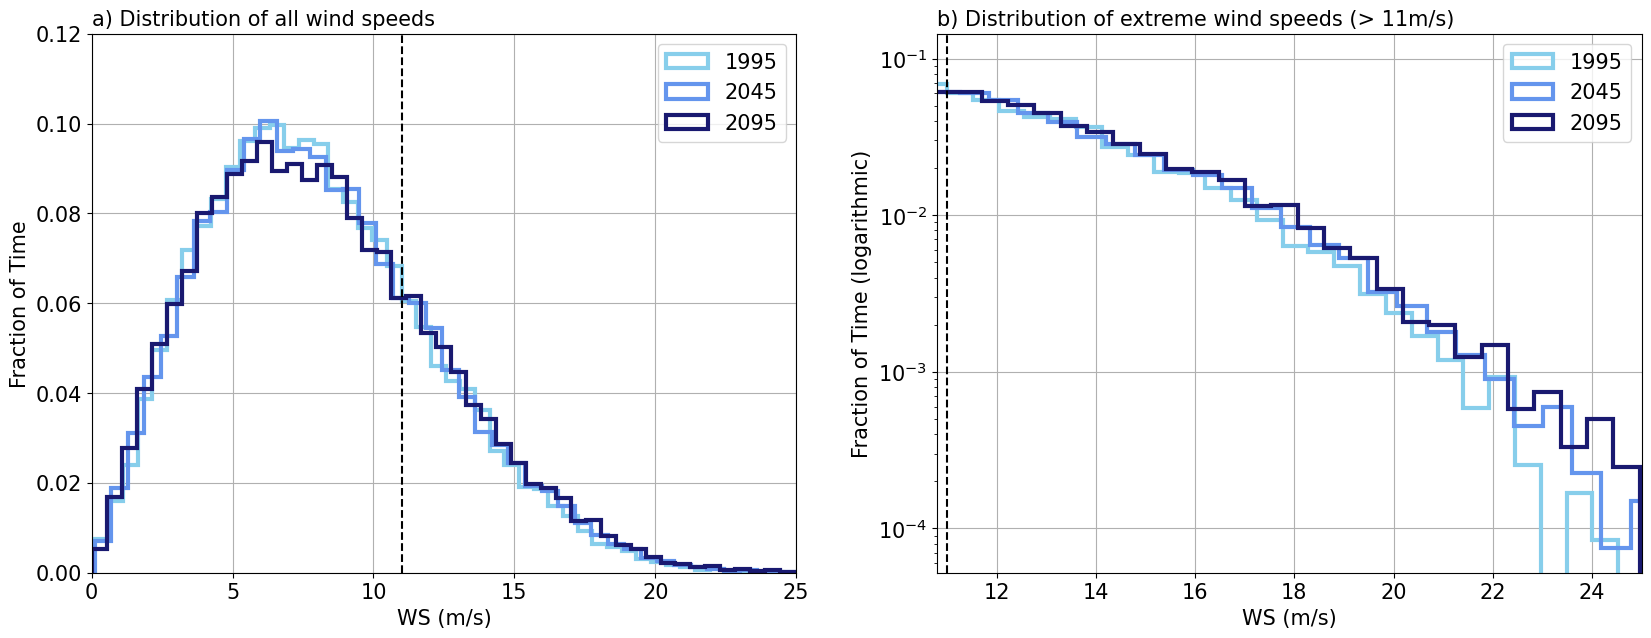

In [32]:
# create figure
fout = 'fig_6_utq_fall_wind_histogram_'+model

fig = plt.figure(figsize=(20,7))

# Make subplot - note it's nrow x ncol x index (starting upper left) - 3 rows x 2 columns
### Plot 3  - WS Histogram ###
ax = fig.add_subplot(1,2,1)
# first decade
ax.hist(ws_dec1, n_bins, color='skyblue', label='1995', density=True, histtype='step', linewidth=3, stacked=True, fill=False)
ax.hist(ws_dec2, n_bins, color='cornflowerblue', label='2045', density=True, histtype='step', linewidth=3, stacked=True, fill=False)
ax.hist(ws_dec3, n_bins, color='midnightblue', label='2095', density=True, histtype='step',linewidth=3, stacked=True, fill=False)
# add vertical line at 11m/s and 17m/s
plt.axvline(x=11, color='black', linestyle='--')
#plt.axvline(x=17, color='black', linestyle='--')
# modify plot
plt.title('a) Distribution of all wind speeds',loc='left',fontsize=15)
plt.xlabel('WS (m/s)',fontsize=15)
plt.xticks(fontsize=15)
plt.xlim([0,25])
plt.ylabel('Fraction of Time',fontsize=15)
plt.yticks(fontsize=15)
plt.ylim([0,0.12])
plt.grid()
plt.legend(loc='upper right', fontsize=15, ncol=1)

### Plot 4  - WS Histogram - Tail ###
ax = fig.add_subplot(1,2,2)
# first decade
ax.hist(ws_dec1, n_bins, color='skyblue', label='1995', density=True, histtype='step', linewidth=3, stacked=True, fill=False)
ax.hist(ws_dec2, n_bins, color='cornflowerblue', label='2045', density=True, histtype='step', linewidth=3, stacked=True, fill=False)
ax.hist(ws_dec3, n_bins, color='midnightblue', label='2095', density=True, histtype='step',linewidth=3, stacked=True, fill=False)
# add vertical line at 11m/s and 17m/s
plt.axvline(x=11, color='black', linestyle='--')
#plt.axvline(x=17, color='black', linestyle='--')
# modify plot
plt.title('b) Distribution of extreme wind speeds (> 11m/s)',loc='left',fontsize=15)
plt.xlabel('WS (m/s)',fontsize=15)
plt.xticks(fontsize=15)
plt.xlim([10.8,25])
#plt.xlim([16.8,25])
plt.ylabel('Fraction of Time (logarithmic)',fontsize=15)
plt.yticks(fontsize=15)
plt.yscale('log')
#plt.ylim([0,0.06])
#plt.ylim([0,0.02])
plt.grid()
plt.legend(loc='upper right', fontsize=15, ncol=1)

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

### Wind Roses

In [27]:
# define a function for windrose colormap
def truncate_colormap(color, minval=0.0, maxval=1.0, n=100):
    cmap = plt.colormaps.get_cmap(color)
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [28]:
# set stuff for wind roses

# truncate colormap
cmap_in = plt.cm.get_cmap('GnBu')
cmap = truncate_colormap(cmap_in, 0.1, 0.9)

# Set bins ranges
windRange = np.array([0, 5, 8, 11, 17])

/glade/derecho/scratch/duvivier/tmp/ipykernel_20639/2559087977.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_in = plt.cm.get_cmap('GnBu')


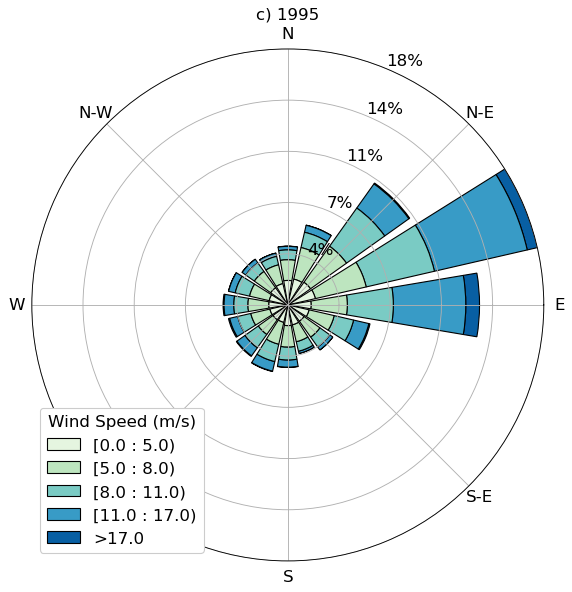

In [29]:
# first decade plot
fout = 'fig_5_utq_fall_windrose_1995_'+model

# data to plot
ws = ws_dec1
wd = wd_dec1
dec_str = 'c) 1995'

# Magically rounds the triangles (triangles to pizza slices if you will)
plt.hist([0, 1])
plt.close()

ax = WindroseAxes.from_ax()
ax.bar(wd, ws, bins = windRange, normed=True, opening=0.85, linewidth=1, edgecolor='black', cmap=cmap)
ax.legend(title='Wind Speed (m/s)',title_fontsize=15, loc='lower left',fontsize=15,framealpha=1)
ax.set_title(dec_str, fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Format radius axis to percentages
fmt = '%.0f%%' 
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

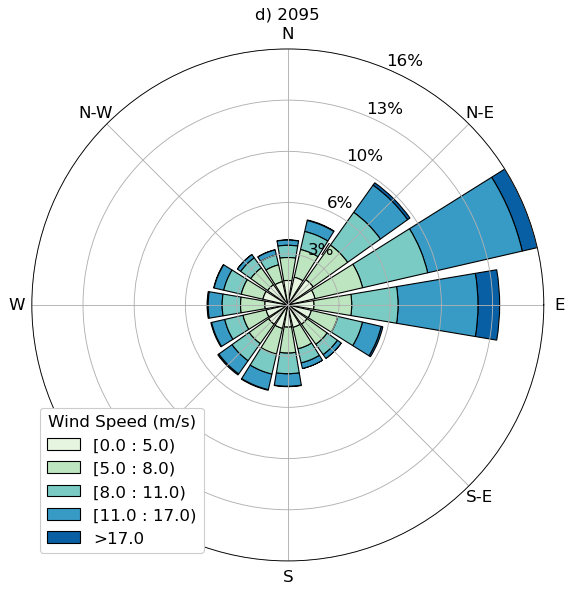

In [30]:
# second decade plot
fout = 'fig_5_utq_fall_windrose_2095_'+model

# data to plot
ws = ws_dec3
wd = wd_dec3
dec_str = 'd) 2095'

# Magically rounds the triangles (triangles to pizza slices if you will)
plt.hist([0, 1])
plt.close()

ax = WindroseAxes.from_ax()
ax.bar(wd, ws, bins = windRange, normed=True, opening=0.85, linewidth=1, edgecolor='black', cmap=cmap)
ax.legend(title='Wind Speed (m/s)',title_fontsize=15, loc='lower left',fontsize=15,framealpha=1)
ax.set_title(dec_str, fontsize = 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Format radius axis to percentages
fmt = '%.0f%%' 
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)